# SimCLR : Training ResNet-20 on CIFAR-10 with augmentations

### Importing necessary dependencies

In [1]:
# import necessary dependencies
import argparse
import os, sys
import time
import datetime
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from pathlib import Path


import torch
import torchvision.transforms as T

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules import Linear

import torchvision
import torchvision.transforms as transforms

from torch.utils.data import DataLoader

from torch.optim.lr_scheduler import StepLR
import resnet20

### Importing net

In [3]:
# Checking presence of cuda and shifting to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("device:", device.type)

# import net
net = resnet20.ResNet().to(device)
# net = torch.nn.DataParallel(net)

device: mps


In [ ]:
# adding projection head


h, s = 512, 256
net.fc = nn.Sequential(nn.Linear(net.fc.in_features, h),
                        nn.ReLU(inplace=True),
                        nn.Linear(h, s),
                        )
net.fc

### Pre-processing functions for data augmentation

In [4]:
# strength of color jitter
s = 1.0

# preprocessing function
transform_train = transforms.Compose([
        transforms.RandomResizedCrop((224,224),
                                scale=(0.08, 1.0), 
                                ratio=(0.75, 1.3333333333333333), 
                                ),
        transforms.RandomHorizontalFlip(),
        transforms.RandomApply([transforms.ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.2*s)], p = 0.8),
        transforms.RandomGrayscale(p=0.2),
        transforms.RandomApply([transforms.GaussianBlur(kernel_size = 3, sigma=(0.1, 2.0))], p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.4914,0.4822,0.4465), std=(0.2023,0.1994,0.2010))
        ])

transform_val = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.4914,0.4822,0.4465), std=(0.2023,0.1994,0.2010))
        ])


### Setting up data-loaders

In [20]:
# do NOT change these
from tools.dataset import CIFAR10
from torch.utils.data import DataLoader

# a few arguments, do NOT change these
DATA_ROOT = "./data"
TRAIN_BATCH_SIZE = 128
VAL_BATCH_SIZE = 100

#############################################
# your code here
# construct dataset
train_set = CIFAR10(
    root=DATA_ROOT, mode="train", download=True, transform=transform_train  # your code
)
val_set = CIFAR10(
    root=DATA_ROOT, mode="val", download=True, transform=transform_val  # your code
)

# construct dataloader
train_loader = DataLoader(
    train_set, batch_size=64, shuffle=True, num_workers=6  # your code  # your code
)
val_loader = DataLoader(
    val_set, batch_size=64, shuffle=False, num_workers=6  # your code  # your code
)

#############################################

Using downloaded and verified file: ./data/cifar10_trainval_F22.zip
Extracting ./data/cifar10_trainval_F22.zip to ./data
Files already downloaded and verified
Using downloaded and verified file: ./data/cifar10_trainval_F22.zip
Extracting ./data/cifar10_trainval_F22.zip to ./data
Files already downloaded and verified


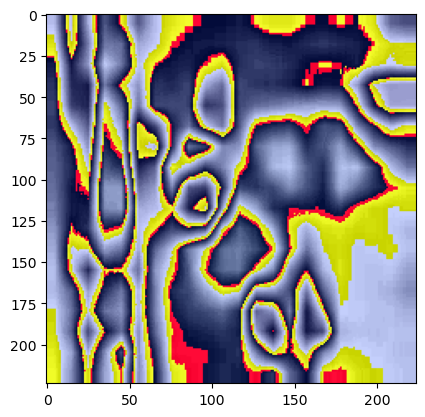

In [23]:
# Plotting an image to check
img = next(iter(train_loader))[0][0]
plt.imshow(transforms.ToPILImage()(img))

In [ ]:
def imshow(img):
  img = img / 2 + 0.5   # unnormalize
  npimg = img.numpy()   # convert from tensor
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog',
    'frog', 'horse', 'ship', 'truck')

# get first 100 training images
# dataiter = iter(train_loader)
# imgs, lbls = dataiter.next()

# image, label = next(iter(train_loader))

# show images
imshow(torchvision.utils.make_grid(img))
# print labels
# print(' '.join(f'{classes[label[j]]:5s}' for j in range(1)))

# for i in range(100):  # show just the frogs
#   if lbls[i] == 0:  # 6 = frog
#     imshow(torchvision.utils.make_grid(imgs[i]))

### Setting up hyperparameters and running net

In [15]:
import torch.nn as nn
import torch.optim as optim

# hyperparameters, do NOT change right now
# initial learning rate
INITIAL_LR = 0.01

# momentum for optimizer
MOMENTUM = 0.9

# L2 regularization strength
REG = 1e-4

#############################################
# your code here
# create loss function
criterion = nn.CrossEntropyLoss().to(device)

# Add optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01)
#############################################


In [16]:
# some hyperparameters
# total number of training epochs
EPOCHS = 200
DECAY_EPOCHS = 7
DECAY = 0.8

# the folder where the trained model is saved
CHECKPOINT_FOLDER = "./saved_model"

# start the training/validation process
# the process should take about 5 minutes on a GTX 1070-Ti
# if the code is written efficiently.
best_val_acc = 0
current_learning_rate = INITIAL_LR

print("==> Training starts!")
print("=" * 50)
for i in range(0, EPOCHS):
    #     # handle the learning rate scheduler.
    #     if i % DECAY_EPOCHS == 0 and i != 0:
    #         current_learning_rate = current_learning_rate * DECAY
    #         for param_group in optimizer.param_groups:
    #             param_group['lr'] = current_learning_rate
    #         print("Current learning rate has decayed to %f" %current_learning_rate)

    #######################
    # your code here
    # switch to train mode
    net.train()

    #######################

    print("Epoch %d:" % i)
    # this help you compute the training accuracy
    total_examples = 0
    correct_examples = 0

    train_loss = 0  # track training loss if you want

    # Train the model for 1 epoch.
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        ####################################
        # your code here
        # copy inputs to device
        inputs = inputs.to(device)
        targets = targets.to(device)

        # compute the output and loss
        outputs = net(inputs)
        loss = criterion(outputs, targets)

        # zero the gradient
        optimizer.zero_grad()

        # backpropagation
        loss.backward()

        # apply gradient and update the weights
        optimizer.step()

        # count the number of correctly predicted samples in the current batch
        _, preds = torch.max(outputs, 1)
        correct = preds.eq(targets).sum()

        total_examples += targets.shape[0]
        train_loss += loss
        correct_examples += correct.item()

        if batch_idx % 100 == 0:
            print("[Batch: {}".format(batch_idx), "\t Loss: {}".format(loss.item()))

        ####################################

    avg_loss = train_loss / len(train_loader)
    avg_acc = correct_examples / total_examples
    print("Training loss: %.4f, Training accuracy: %.4f" % (avg_loss, avg_acc))

    # Validate on the validation dataset
    #######################
    # your code here
    # switch to eval mode
    net.eval()

    #######################

    # this help you compute the validation accuracy
    total_examples = 0
    correct_examples = 0

    val_loss = 0  # again, track the validation loss if you want

    # disable gradient during validation, which can save GPU memory
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            ####################################
            # your code here
            # copy inputs to device
            inputs = inputs.to(device)
            targets = targets.to(device)

            # compute the output and loss
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            # count the number of correctly predicted samples in the current batch
            _, preds = torch.max(outputs, 1)
            correct = preds.eq(targets).sum()

            val_loss += loss
            correct_examples += correct.item()
            total_examples += targets.shape[0]

            ####################################

    avg_loss = val_loss / len(val_loader)
    avg_acc = correct_examples / total_examples
    print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))

    # save the model checkpoint
    if avg_acc > best_val_acc:
        best_val_acc = avg_acc
        if not os.path.exists(CHECKPOINT_FOLDER):
            os.makedirs(CHECKPOINT_FOLDER)
        print("Saving ...")
        state = {
            "state_dict": net.state_dict(),
            "epoch": i,
            "lr": current_learning_rate,
        }
        torch.save(state, os.path.join(CHECKPOINT_FOLDER, "resnet_dev0.pth"))

    print("")

print("=" * 50)
print(f"==> Optimization finished! Best validation accuracy: {best_val_acc:.4f}")


==> Training starts!
Epoch 0:
[Batch: 0 	 Loss: 2.7622556686401367
[Batch: 100 	 Loss: 1.9255136251449585
[Batch: 200 	 Loss: 1.869916558265686
[Batch: 300 	 Loss: 1.839647889137268
[Batch: 400 	 Loss: 1.7239187955856323
[Batch: 500 	 Loss: 1.8247097730636597
[Batch: 600 	 Loss: 1.73231041431427
[Batch: 700 	 Loss: 1.6913790702819824
Training loss: 1.8437, Training accuracy: 0.3104
Validation loss: 1.5860, Validation accuracy: 0.4162
Saving ...

Epoch 1:
[Batch: 0 	 Loss: 1.7485394477844238
[Batch: 100 	 Loss: 1.6953669786453247
[Batch: 200 	 Loss: 1.3940479755401611
[Batch: 300 	 Loss: 1.59556245803833
[Batch: 400 	 Loss: 1.5967105627059937
[Batch: 500 	 Loss: 1.5342155694961548
[Batch: 600 	 Loss: 1.4699475765228271
[Batch: 700 	 Loss: 1.5744549036026
Training loss: 1.5507, Training accuracy: 0.4374
Validation loss: 1.3037, Validation accuracy: 0.5136
Saving ...

Epoch 2:
[Batch: 0 	 Loss: 1.5088984966278076
[Batch: 100 	 Loss: 1.2767868041992188
[Batch: 200 	 Loss: 1.542088270187378

## Lab 3(b) Tuning hyperparameters for ResNet-20

### iter with (higher lr, grad clip, nesterov, higher decay)

In [17]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, stride, downsample=None):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels, out_channels, kernel_size=3, stride=stride, padding=1
        )
        self.conv1_bn = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(
            out_channels, out_channels, kernel_size=3, stride=1, padding=1
        )
        self.conv2_bn = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = F.relu(self.conv1_bn(self.conv1(x)))
        out = self.conv2_bn(self.conv2(out))

        if self.downsample:
            residual = self.downsample(x)

        out = out + residual
        out = F.relu(out)
        return out


# def _weights_init(m):
#     classname = m.__class__.__name__
#     #print(classname)
#     if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
#         # nn.init.xavier_normal_(m.weight)
#         nn.init.kaiming_normal_(m.weight)


class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv11 = nn.Conv2d(3, 16, kernel_size=3, padding=1, stride=1)
        self.conv11_bn = nn.BatchNorm2d(16)
        self.layer_1 = self.make_layer(16, stride=1)
        self.layer_2 = self.make_layer(32, stride=2)
        self.layer_3 = self.make_layer(64, stride=2)
        self.avgpool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, 10)
        # self.apply(_weights_init)

    def make_layer(self, out_channels, stride=1):
        self.downsample = None
        if stride != 1:  # or self.in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels, out_channels, kernel_size=1, padding=0, stride=2
                ),
                nn.BatchNorm2d(out_channels),
            )

        layers_strides = [stride] + [1, 1]
        layers = []
        for stride_i in layers_strides:
            layers.append(
                Block(self.in_channels, out_channels, stride_i, self.downsample)
            )
            self.downsample = None
            self.in_channels = out_channels

        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.conv11_bn(self.conv11(x)))
        out = self.layer_1(out)
        out = self.layer_2(out)
        out = self.layer_3(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device.type)

net = ResNet().to(device)
net = torch.nn.DataParallel(net)


device: cuda


In [19]:
#############################################
# specify preprocessing function
transform_train = transforms.Compose(
    [
        transforms.RandomCrop(32, 4),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)
        ),
    ]
)

transform_val = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(
            mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)
        ),
    ]
)
#############################################


In [20]:
# do NOT change these
from tools.dataset import CIFAR10
from torch.utils.data import DataLoader

# a few arguments, do NOT change these
DATA_ROOT = "./data"
TRAIN_BATCH_SIZE = 128
VAL_BATCH_SIZE = 100

#############################################
# your code here
# construct dataset
train_set = CIFAR10(
    root=DATA_ROOT, mode="train", download=True, transform=transform_train  # your code
)
val_set = CIFAR10(
    root=DATA_ROOT, mode="val", download=True, transform=transform_val  # your code
)

# construct dataloader
train_loader = DataLoader(
    train_set, batch_size=64, shuffle=True, num_workers=10  # your code  # your code
)
val_loader = DataLoader(
    val_set, batch_size=64, shuffle=False, num_workers=10  # your code  # your code
)

#############################################


Using downloaded and verified file: ./data/cifar10_trainval_F22.zip
Extracting ./data/cifar10_trainval_F22.zip to ./data
Files already downloaded and verified
Using downloaded and verified file: ./data/cifar10_trainval_F22.zip
Extracting ./data/cifar10_trainval_F22.zip to ./data
Files already downloaded and verified


In [21]:
import torch.nn as nn
import torch.optim as optim

# hyperparameters, do NOT change right now
# initial learning rate
INITIAL_LR = 0.02

# momentum for optimizer
MOMENTUM = 0.9

# L2 regularization strength
REG = 1e-4

#############################################
# your code here
# create loss function
criterion = nn.CrossEntropyLoss().to(device)

# Add optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01, nesterov=True, momentum=MOMENTUM)
#############################################


In [22]:
# some hyperparameters
# total number of training epochs
EPOCHS = 200
DECAY_EPOCHS = 80
DECAY = 0.9

# the folder where the trained model is saved
CHECKPOINT_FOLDER = "./saved_model"

# start the training/validation process
# the process should take about 5 minutes on a GTX 1070-Ti
# if the code is written efficiently.
best_val_acc = 0
current_learning_rate = INITIAL_LR

print("==> Training starts!")
print("=" * 50)
for i in range(0, EPOCHS):
    #     # handle the learning rate scheduler.
    if i % DECAY_EPOCHS == 0 and i != 0:
        current_learning_rate = current_learning_rate * DECAY
        for param_group in optimizer.param_groups:
            param_group["lr"] = current_learning_rate
        print("Current learning rate has decayed to %f" % current_learning_rate)

    #######################
    # your code here
    # switch to train mode
    net.train()

    #######################

    print("Epoch %d:" % i)
    # this help you compute the training accuracy
    total_examples = 0
    correct_examples = 0

    train_loss = 0  # track training loss if you want

    # Train the model for 1 epoch.
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        ####################################
        # your code here
        # copy inputs to device
        inputs = inputs.to(device)
        targets = targets.to(device)

        # compute the output and loss
        outputs = net(inputs)
        loss = criterion(outputs, targets)

        # zero the gradient
        optimizer.zero_grad()

        # backpropagation
        loss.backward()

        # apply gradient and update the weights
        nn.utils.clip_grad_value_(net.parameters(), clip_value=1.0)
        optimizer.step()

        # count the number of correctly predicted samples in the current batch
        _, preds = torch.max(outputs, 1)
        correct = preds.eq(targets).sum()

        total_examples += targets.shape[0]
        train_loss += loss
        correct_examples += correct.item()

        if batch_idx % 100 == 0:
            print("[Batch: {}".format(batch_idx), "\t Loss: {}".format(loss.item()))

        ####################################

    avg_loss = train_loss / len(train_loader)
    avg_acc = correct_examples / total_examples
    print("Training loss: %.4f, Training accuracy: %.4f" % (avg_loss, avg_acc))

    # Validate on the validation dataset
    #######################
    # your code here
    # switch to eval mode
    net.eval()

    #######################

    # this help you compute the validation accuracy
    total_examples = 0
    correct_examples = 0

    val_loss = 0  # again, track the validation loss if you want

    # disable gradient during validation, which can save GPU memory
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            ####################################
            # your code here
            # copy inputs to device
            inputs = inputs.to(device)
            targets = targets.to(device)

            # compute the output and loss
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            # count the number of correctly predicted samples in the current batch
            _, preds = torch.max(outputs, 1)
            correct = preds.eq(targets).sum()

            val_loss += loss
            correct_examples += correct.item()
            total_examples += targets.shape[0]

            ####################################

    avg_loss = val_loss / len(val_loader)
    avg_acc = correct_examples / total_examples
    print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))

    # save the model checkpoint
    if avg_acc > best_val_acc:
        best_val_acc = avg_acc
        if not os.path.exists(CHECKPOINT_FOLDER):
            os.makedirs(CHECKPOINT_FOLDER)
        print("Saving ...")
        state = {
            "state_dict": net.state_dict(),
            "epoch": i,
            "lr": current_learning_rate,
        }
        torch.save(state, os.path.join(CHECKPOINT_FOLDER, "resnet_dev5_2.pth"))

    print("")

# torch.save(net.state_dict(),"resnet_dev1.pth")

print("=" * 50)
print(f"==> Optimization finished! Best validation accuracy: {best_val_acc:.4f}")


==> Training starts!
Epoch 0:
[Batch: 0 	 Loss: 2.470926284790039
[Batch: 100 	 Loss: 1.9310129880905151
[Batch: 200 	 Loss: 1.6948561668395996
[Batch: 300 	 Loss: 1.4884189367294312
[Batch: 400 	 Loss: 1.3885345458984375
[Batch: 500 	 Loss: 1.2497719526290894
[Batch: 600 	 Loss: 1.2593333721160889
[Batch: 700 	 Loss: 1.2765244245529175
Training loss: 1.5784, Training accuracy: 0.4200
Validation loss: 1.4867, Validation accuracy: 0.5138
Saving ...

Epoch 1:
[Batch: 0 	 Loss: 1.219628095626831
[Batch: 100 	 Loss: 0.9922858476638794
[Batch: 200 	 Loss: 1.0516819953918457
[Batch: 300 	 Loss: 1.2007076740264893
[Batch: 400 	 Loss: 1.0379036664962769
[Batch: 500 	 Loss: 0.9867838025093079
[Batch: 600 	 Loss: 1.1571354866027832
[Batch: 700 	 Loss: 0.8956583738327026
Training loss: 1.1186, Training accuracy: 0.6078
Validation loss: 1.0988, Validation accuracy: 0.6234
Saving ...

Epoch 2:
[Batch: 0 	 Loss: 0.9972339272499084
[Batch: 100 	 Loss: 1.0221339464187622
[Batch: 200 	 Loss: 0.78059530

### iter with (higher lr, grad clip, nesterov, lesser decay)

In [23]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, stride, downsample=None):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels, out_channels, kernel_size=3, stride=stride, padding=1
        )
        self.conv1_bn = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(
            out_channels, out_channels, kernel_size=3, stride=1, padding=1
        )
        self.conv2_bn = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = F.relu(self.conv1_bn(self.conv1(x)))
        out = self.conv2_bn(self.conv2(out))

        if self.downsample:
            residual = self.downsample(x)

        out = out + residual
        out = F.relu(out)
        return out


# def _weights_init(m):
#     classname = m.__class__.__name__
#     #print(classname)
#     if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
#         # nn.init.xavier_normal_(m.weight)
#         nn.init.kaiming_normal_(m.weight)


class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv11 = nn.Conv2d(3, 16, kernel_size=3, padding=1, stride=1)
        self.conv11_bn = nn.BatchNorm2d(16)
        self.layer_1 = self.make_layer(16, stride=1)
        self.layer_2 = self.make_layer(32, stride=2)
        self.layer_3 = self.make_layer(64, stride=2)
        self.avgpool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, 10)
        # self.apply(_weights_init)

    def make_layer(self, out_channels, stride=1):
        self.downsample = None
        if stride != 1:  # or self.in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels, out_channels, kernel_size=1, padding=0, stride=2
                ),
                nn.BatchNorm2d(out_channels),
            )

        layers_strides = [stride] + [1, 1]
        layers = []
        for stride_i in layers_strides:
            layers.append(
                Block(self.in_channels, out_channels, stride_i, self.downsample)
            )
            self.downsample = None
            self.in_channels = out_channels

        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.conv11_bn(self.conv11(x)))
        out = self.layer_1(out)
        out = self.layer_2(out)
        out = self.layer_3(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device.type)

net = ResNet().to(device)
net = torch.nn.DataParallel(net)


device: cuda


In [25]:
#############################################
# specify preprocessing function
transform_train = transforms.Compose(
    [
        transforms.RandomCrop(32, 4),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)
        ),
    ]
)

transform_val = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(
            mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)
        ),
    ]
)
#############################################


In [26]:
# do NOT change these
from tools.dataset import CIFAR10
from torch.utils.data import DataLoader

# a few arguments, do NOT change these
DATA_ROOT = "./data"
TRAIN_BATCH_SIZE = 128
VAL_BATCH_SIZE = 100

#############################################
# your code here
# construct dataset
train_set = CIFAR10(
    root=DATA_ROOT, mode="train", download=True, transform=transform_train  # your code
)
val_set = CIFAR10(
    root=DATA_ROOT, mode="val", download=True, transform=transform_val  # your code
)

# construct dataloader
train_loader = DataLoader(
    train_set, batch_size=64, shuffle=True, num_workers=10  # your code  # your code
)
val_loader = DataLoader(
    val_set, batch_size=64, shuffle=False, num_workers=10  # your code  # your code
)

#############################################


Using downloaded and verified file: ./data/cifar10_trainval_F22.zip
Extracting ./data/cifar10_trainval_F22.zip to ./data
Files already downloaded and verified
Using downloaded and verified file: ./data/cifar10_trainval_F22.zip
Extracting ./data/cifar10_trainval_F22.zip to ./data
Files already downloaded and verified


In [27]:
import torch.nn as nn
import torch.optim as optim

# hyperparameters, do NOT change right now
# initial learning rate
INITIAL_LR = 0.02

# momentum for optimizer
MOMENTUM = 0.9

# L2 regularization strength
REG = 1e-4

#############################################
# your code here
# create loss function
criterion = nn.CrossEntropyLoss().to(device)

# Add optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01, nesterov=True, momentum=MOMENTUM)
#############################################


In [28]:
# some hyperparameters
# total number of training epochs
EPOCHS = 200
DECAY_EPOCHS = 80
DECAY = 0.6

# the folder where the trained model is saved
CHECKPOINT_FOLDER = "./saved_model"

# start the training/validation process
# the process should take about 5 minutes on a GTX 1070-Ti
# if the code is written efficiently.
best_val_acc = 0
current_learning_rate = INITIAL_LR

print("==> Training starts!")
print("=" * 50)
for i in range(0, EPOCHS):
    #     # handle the learning rate scheduler.
    if i % DECAY_EPOCHS == 0 and i != 0:
        current_learning_rate = current_learning_rate * DECAY
        for param_group in optimizer.param_groups:
            param_group["lr"] = current_learning_rate
        print("Current learning rate has decayed to %f" % current_learning_rate)

    #######################
    # your code here
    # switch to train mode
    net.train()

    #######################

    print("Epoch %d:" % i)
    # this help you compute the training accuracy
    total_examples = 0
    correct_examples = 0

    train_loss = 0  # track training loss if you want

    # Train the model for 1 epoch.
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        ####################################
        # your code here
        # copy inputs to device
        inputs = inputs.to(device)
        targets = targets.to(device)

        # compute the output and loss
        outputs = net(inputs)
        loss = criterion(outputs, targets)

        # zero the gradient
        optimizer.zero_grad()

        # backpropagation
        loss.backward()

        # apply gradient and update the weights
        nn.utils.clip_grad_value_(net.parameters(), clip_value=1.0)
        optimizer.step()

        # count the number of correctly predicted samples in the current batch
        _, preds = torch.max(outputs, 1)
        correct = preds.eq(targets).sum()

        total_examples += targets.shape[0]
        train_loss += loss
        correct_examples += correct.item()

        if batch_idx % 100 == 0:
            print("[Batch: {}".format(batch_idx), "\t Loss: {}".format(loss.item()))

        ####################################

    avg_loss = train_loss / len(train_loader)
    avg_acc = correct_examples / total_examples
    print("Training loss: %.4f, Training accuracy: %.4f" % (avg_loss, avg_acc))

    # Validate on the validation dataset
    #######################
    # your code here
    # switch to eval mode
    net.eval()

    #######################

    # this help you compute the validation accuracy
    total_examples = 0
    correct_examples = 0

    val_loss = 0  # again, track the validation loss if you want

    # disable gradient during validation, which can save GPU memory
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            ####################################
            # your code here
            # copy inputs to device
            inputs = inputs.to(device)
            targets = targets.to(device)

            # compute the output and loss
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            # count the number of correctly predicted samples in the current batch
            _, preds = torch.max(outputs, 1)
            correct = preds.eq(targets).sum()

            val_loss += loss
            correct_examples += correct.item()
            total_examples += targets.shape[0]

            ####################################

    avg_loss = val_loss / len(val_loader)
    avg_acc = correct_examples / total_examples
    print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))

    # save the model checkpoint
    if avg_acc > best_val_acc:
        best_val_acc = avg_acc
        if not os.path.exists(CHECKPOINT_FOLDER):
            os.makedirs(CHECKPOINT_FOLDER)
        print("Saving ...")
        state = {
            "state_dict": net.state_dict(),
            "epoch": i,
            "lr": current_learning_rate,
        }
        torch.save(state, os.path.join(CHECKPOINT_FOLDER, "resnet_dev6.pth"))

    print("")

# torch.save(net.state_dict(),"resnet_dev1.pth")

print("=" * 50)
print(f"==> Optimization finished! Best validation accuracy: {best_val_acc:.4f}")


==> Training starts!
Epoch 0:
[Batch: 0 	 Loss: 2.411863088607788
[Batch: 100 	 Loss: 1.7556411027908325
[Batch: 200 	 Loss: 1.7169841527938843
[Batch: 300 	 Loss: 1.6341516971588135
[Batch: 400 	 Loss: 1.4326646327972412
[Batch: 500 	 Loss: 1.2034151554107666
[Batch: 600 	 Loss: 1.358628749847412
[Batch: 700 	 Loss: 1.3296419382095337
Training loss: 1.6100, Training accuracy: 0.4082
Validation loss: 1.5405, Validation accuracy: 0.4884
Saving ...

Epoch 1:
[Batch: 0 	 Loss: 1.1570252180099487
[Batch: 100 	 Loss: 1.0224828720092773
[Batch: 200 	 Loss: 1.137739658355713
[Batch: 300 	 Loss: 1.2144510746002197
[Batch: 400 	 Loss: 1.1338814496994019
[Batch: 500 	 Loss: 0.9397361278533936
[Batch: 600 	 Loss: 0.862381100654602
[Batch: 700 	 Loss: 1.1919071674346924
Training loss: 1.1597, Training accuracy: 0.5922
Validation loss: 1.1135, Validation accuracy: 0.6200
Saving ...

Epoch 2:
[Batch: 0 	 Loss: 0.8845921754837036
[Batch: 100 	 Loss: 1.1232225894927979
[Batch: 200 	 Loss: 1.1133837699